# Map visualizations and geographic analysis (Matt)

In [1]:
# imports and setup
from   adjustText import adjust_text
from   ast import literal_eval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.io.img_tiles import MapboxTiles
from   collections import Counter, defaultdict
import fightinwords as fw
from   itertools import pairwise
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   sklearn.feature_extraction.text import CountVectorizer
import string
from   unidecode import unidecode

data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
fig_dir = os.path.join('..', 'figures')

conlit_input_file = 'CONLIT_CharData_AP_MW_11.csv.gz'
early_input_file = 'EARLY_CharData_AP_MW_11.csv.gz'

home_dir = os.path.expanduser('~')
mapbox_key_file = f'{home_dir}/Library/CloudStorage/GoogleDrive-mw966@cornell.edu/My Drive/Private/mapbox-api-key.txt'

## CONLIT

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_input_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit = conlit.fillna('')
conlit.replace([np.inf, -np.inf], np.nan, inplace=True)
conlit.rename(columns={'source':'collection'}, inplace=True)
conlit.loc[conlit.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

### Geo data for CONLIT

In [3]:
# regularize data to wilkens geo format
punctuation_to_space = str.maketrans({key:' ' for key in string.punctuation})

def regularize_string(place_string):
    return(unidecode(' '.join(place_string.translate(punctuation_to_space).lower().split())))

wi = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wi = wi.loc[wi.lang=='en']
wi.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'
hand.loc['baltic', ['ignore', 'alias_to']] = [0, 'baltic sea']

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (~hand.ignore.equals(1)) & (hand.alias_to.isin(wi.index)), 'alias_to'].items():
    wi.loc[original_place] = wi.loc[alias_to]
    
# drop ignored places
wi.drop(hand.loc[hand.ignore==1].index, inplace=True, errors='ignore')

In [4]:
# drop unused places
wi_gpes = Counter()
for sequence in conlit.gpe_sequences:
    wi_gpes.update([regularize_string(i) for i in sequence])
wi.drop(wi.loc[~wi.index.isin(wi_gpes)].index, inplace=True, errors='ignore')

### CONLIT mapping

In [5]:
def get_lat_lon(place_string, geo_data=wi, extended=False):
    '''Assumes lookup string has been regularized if necessary'''
    try:
        if extended:
            return(geo_data.loc[place_string, ['lat', 'lon', 'country_short', 'admin_1_std', 'location_type']])
        else:
            return(geo_data.loc[place_string, ['lat', 'lon']])
    except (ValueError, KeyError):
        return(None)

# def get_route(list_of_places, geo_data=wi):
#     '''Takes a list of locations, returns a list of lat-lon tuples'''
#     route = []
#     seq = [regularize_string(i) for i in list_of_places if regularize_string(i) in geo_data.index]
#     for place in list_of_places:
#         route.append(get_lat_lon(place, geo_data=geo_data))
#     return(pd.DataFrame(route))

def get_hops(list_of_places, geo_data=wi):
    '''Takes a list oflocations, returns a list of origin-destination lat/lon tuples'''
    hop_list = []
    seq = [regularize_string(i) for i in list_of_places if regularize_string(i) in geo_data.index]
    for location1, location2 in pairwise(seq):
        loc1 = get_lat_lon(location1, geo_data, extended=True)
        loc2 = get_lat_lon(location2, geo_data, extended=True)
        if loc1 is None or loc2 is None: pass # should never happen, but check
        elif loc1.equals(loc2): pass # ignore identical places, even if called different names
        # eliminate place -> higher-order place in same admin area
        elif (loc1.location_type=='country' or loc2.location_type=='country') and \
           (loc2.country_short==loc1.country_short): pass
        elif (loc1.location_type=='administrative_area_level_1' or \
              loc2.location_type=='administrative_area_level_1') and \
             (loc2.country_short==loc1.country_short and \
              loc2.admin_1_std==loc1.admin_1_std): pass
        else:
            loc1 = tuple(loc1[['lat', 'lon']])
            loc2 = tuple(loc2[['lat', 'lon']])   
            hop_list.append((loc1, loc2))
    return(hop_list)

In [6]:
# get lat/lon data for all hops in all books
conlit_hops = conlit.gpe_sequences.apply(get_hops)

conlit_hops_counter = Counter()
for book in conlit_hops:
    for pair in book:
        hop = sorted(pair)
        conlit_hops_counter[tuple(hop)] += 1

CPU times: user 1min 24s, sys: 2.4 s, total: 1min 26s
Wall time: 1min 33s


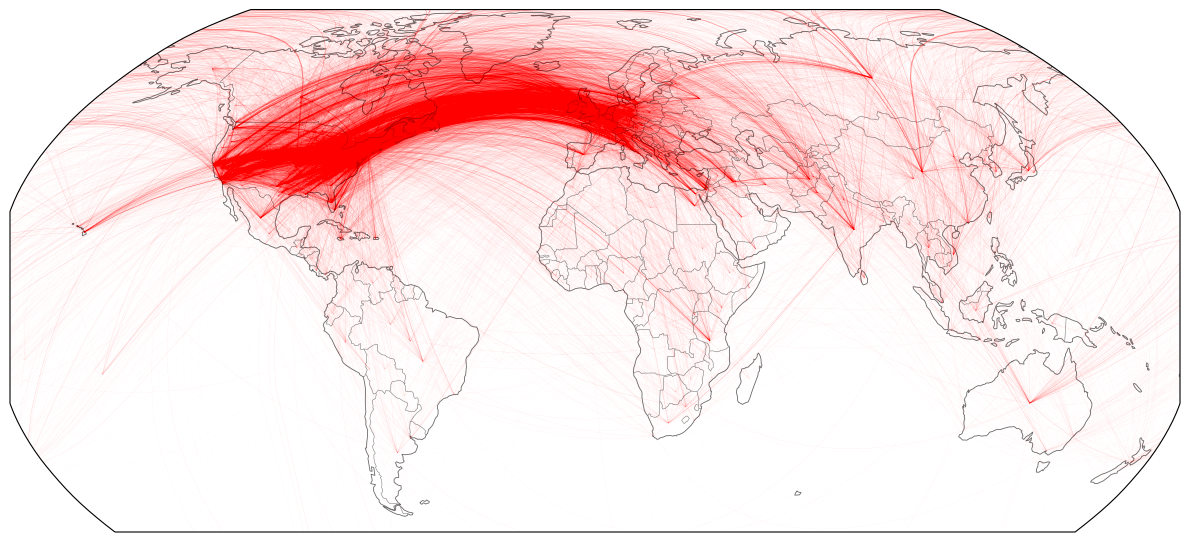

In [7]:
%%time
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-175, 175, -60, 85])
sizefactor = 1000/conlit_hops_counter.total()
for hop in conlit_hops_counter:
    plt.plot(
        [i[1] for i in hop],
        [i[0] for i in hop], 
        color='red', 
        marker=None, 
        alpha=0.4, 
        linewidth=conlit_hops_counter[hop]*sizefactor,
        transform=ccrs.Geodetic()
    )
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
fig.canvas.draw()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'world_hop_map_CONLIT')+'.png', dpi=300)

In [8]:
print(f'Total CONLIT hops: {conlit_hops_counter.total()}')

Total CONLIT hops: 79899


## EARLY

In [9]:
early = pd.read_csv(
    os.path.join(derived_dir, early_input_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early = early.fillna('')
early.replace([np.inf, -np.inf], np.nan, inplace=True)
early.loc[early.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

### Geo data for EARLY

In [10]:
# reread geo data to retain relevant locations, etc.
wie = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wie = wie.loc[wie.lang=='en']
wie.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'
hand.loc['baltic', ['ignore', 'alias_to']] = [0, 'baltic sea']

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (~hand.ignore.equals(1)) & (hand.alias_to.isin(wie.index)), 'alias_to'].items():
    wie.loc[original_place] = wie.loc[alias_to]

# drop ignored places
wie = wie.drop(hand.loc[hand.ignore==1].index, errors='ignore')

# drop unused places
wie_gpes = Counter()
for sequence in early.gpe_sequences:
    wie_gpes.update([regularize_string(i) for i in sequence])
wie.drop(wie.loc[~wie.index.isin(wie_gpes)].index, inplace=True, errors='ignore')

In [11]:
# drop unused places
wie_gpes = Counter()
for sequence in early.gpe_sequences:
    wie_gpes.update([regularize_string(i) for i in sequence])
wie.drop(wie.loc[~wie.index.isin(wie_gpes)].index, inplace=True, errors='ignore')

### EARLY mapping

In [12]:
# get lat/lon data for all hops in all books
early_hops = early.gpe_sequences.apply(get_hops, {'geo_data':wie})

early_hops_counter = Counter()
for book in early_hops:
    for pair in book:
        hop = sorted(pair)
        early_hops_counter[tuple(hop)] += 1

/var/folders/xd/m092nj891q71xlv9zcn1sd8r0000gn/T/ipykernel_8010/1350954246.py:2: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  early_hops = early.gpe_sequences.apply(get_hops, {'geo_data':wie})


CPU times: user 1min 27s, sys: 303 ms, total: 1min 27s
Wall time: 1min 27s


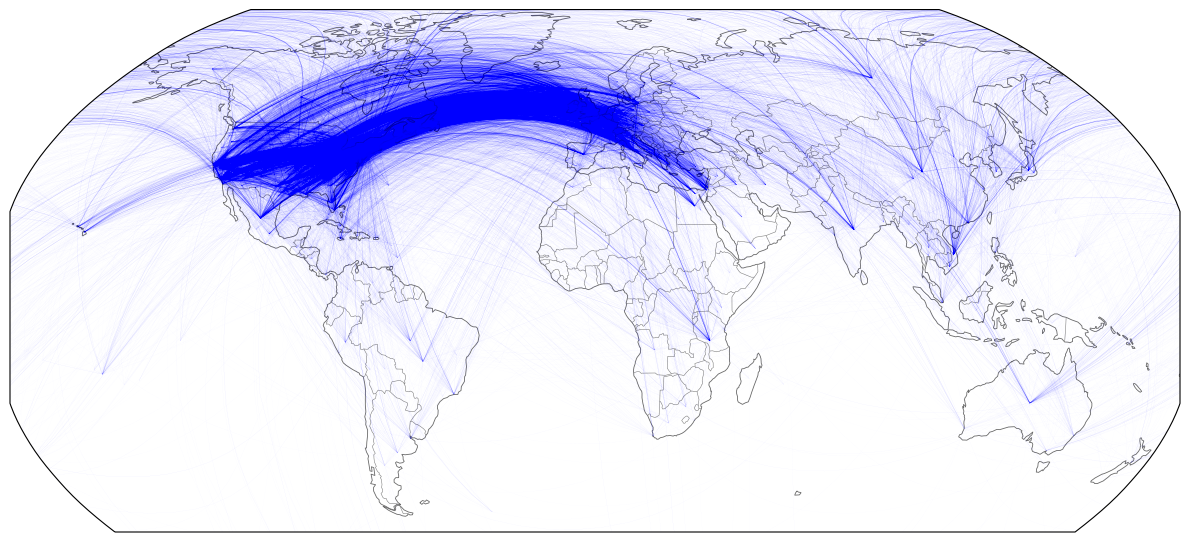

In [13]:
%%time
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-175, 175, -60, 85])
sizefactor = 1000/early_hops_counter.total()
for hop in early_hops_counter:
    plt.plot(
        [i[1] for i in hop],
        [i[0] for i in hop], 
        color='blue', 
        marker=None, 
        alpha=0.4, 
        linewidth=early_hops_counter[hop]*sizefactor,
        transform=ccrs.Geodetic()
    )
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
fig.canvas.draw()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'world_hop_map_EARLY')+'.png', dpi=300)

In [14]:
print(f'Total EARLY hops: {early_hops_counter.total()}')

Total EARLY hops: 113581


## Combined

In [15]:
all_hops_counter = early_hops_counter + conlit_hops_counter
print(f'Total combined hops: {all_hops_counter.total()}')

Total combined hops: 193480


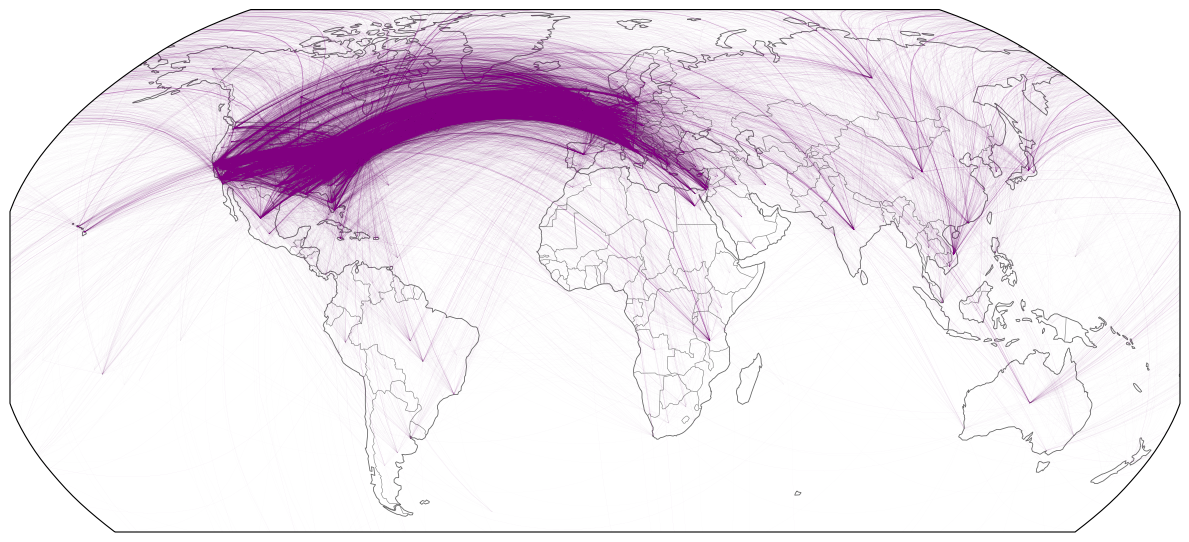

In [16]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-175, 175, -60, 85])
sizefactor = 1000/early_hops_counter.total()
for hop in early_hops_counter:
    plt.plot(
        [i[1] for i in hop],
        [i[0] for i in hop], 
        color='purple', 
        marker=None, 
        alpha=0.4, 
        linewidth=early_hops_counter[hop]*sizefactor,
        transform=ccrs.Geodetic()
    )
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
fig.canvas.draw()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'world_hop_map_ALL')+'.png', dpi=300)

# Fightin' Words

For the method, see [Monroe et al. (2008)](https://languagelog.ldc.upenn.edu/myl/Monroe.pdf). We're using the full-fat version with an informative Dirichlet prior (section 3.5.1, eq. 23).

In [17]:
# read full dataset from disk
data = pd.read_csv(
    os.path.join(derived_dir, 'ALL_CharData_AP_MW_11.csv.gz'),
    index_col='book_id',
    converters={
    'gpe_places': string_to_list,
    'nongpe_places': string_to_list,
    'all_places': string_to_list,
    'gpe_sequences': string_to_list
    }
)

In [18]:
# functions to display and plot fightinwords results
# FW display output as text
def display_fw(data, n=10, name1='corpus one', name2='corpus two'):
    '''Display the indicated number of top terms from fightinwords output.'''
    print("Top terms in", name1)
    for term, score in reversed(data[-n:]):
        print(f"{term:<15} {score:6.2f}")
    print("")
    print("Top terms in", name2)
    for term, score in data[:n]:
        print(f"{term:<15} {score:6.2f}")

# plot FW results
def plot_fw(
    fw_results, 
    fw_input_array, 
    fw_vocabulary, 
    num_words_to_plot=20,
    label1='Group 1',
    label2='Group 2',
    alpha=0.8,
    name='output',
    print_result=False
):
    
    # convert to dataframe for convenience
    df = pd.DataFrame(fw_input_array, columns=fw_vocabulary)
        
    # manage data for plotting
    frequencies = []
    zscores = []
    words = []
    for word, z_score in fw_results:
        count = df[word].sum()
        if count > 0:
            zscores.append(z_score)
            words.append(word)
            frequencies.append(count)
    
    # plot result
    texts = []
    fig, ax = plt.subplots(1,1)
    
    ax.scatter(
        np.log10(frequencies[-num_words_to_plot:]), 
        zscores[-num_words_to_plot:], 
        alpha=alpha, 
        label=label1
    )
    ax.scatter(
        np.log10(frequencies[:num_words_to_plot]), 
        zscores[:num_words_to_plot], 
        alpha=alpha, 
        label=label2
    )
    
    for i in range(-num_words_to_plot, num_words_to_plot):
        texts.append(ax.text(np.log10(frequencies[i]), zscores[i], words[i], size='small', alpha=0.6))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    plt.xlabel('log(frequency)')
    plt.ylabel('z-score')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f'fightinwords_{name}')+'.png', dpi=300)
    plt.show()

    if print_result:
        display_fw(fw_results, n=num_words_to_plot, name1=label1, name2=label2)

In [19]:
# set up vectorizer and get reference counts

# regularize place data
punctuation_to_space = str.maketrans({key:' ' for key in string.punctuation})

def regularize_string(place_string):
    return(unidecode(' '.join(place_string.translate(punctuation_to_space).lower().split())))

# GPEs
cv = CountVectorizer(
    tokenizer=lambda x: x, 
    token_pattern=None,
    preprocessor=lambda x: [regularize_string(i) for i in x],
    #lowercase=True,
    #strip_accents='unicode',
    min_df=3
)
gpe_array = cv.fit_transform(data.gpe_places).toarray()
gpe_prior = gpe_array.sum(axis=0)

In [20]:
# Non-GPEs
cv_non = CountVectorizer(
    tokenizer=lambda x: x, 
    token_pattern=None,
    preprocessor=lambda x: [regularize_string(i) for i in x],
    min_df=10
)
nongpe_array = cv_non.fit_transform(data.nongpe_places).toarray()
nongpe_prior = nongpe_array.sum(axis=0)


Comparing GPEs in Fiction vs. Nonfiction
Vocab size is 6322
Comparing language...


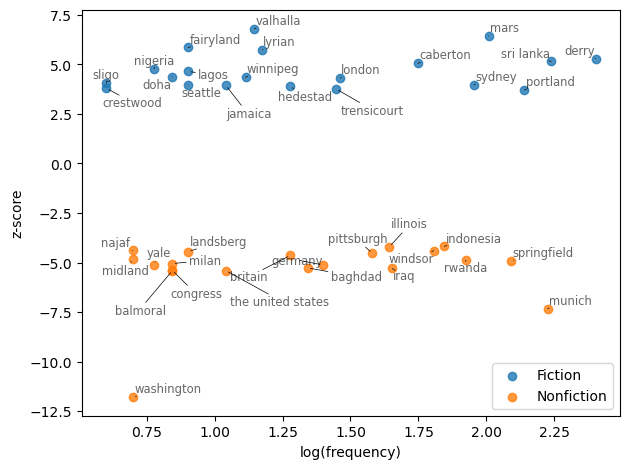

Top terms in Fiction
valhalla          6.80
mars              6.43
fairyland         5.85
lyrian            5.73
derry             5.29
sri lanka         5.15
caberton          5.06
nigeria           4.78
lagos             4.65
doha              4.37
winnipeg          4.36
london            4.31
sligo             4.05
sydney            3.98
seattle           3.97
jamaica           3.94
hedestad          3.91
crestwood         3.80
trensicourt       3.76
portland          3.71

Top terms in Nonfiction
washington      -11.80
munich           -7.32
balmoral         -5.41
the united states  -5.41
congress         -5.40
iraq             -5.30
baghdad          -5.27
germany          -5.12
yale             -5.12
milan            -5.05
springfield      -4.92
rwanda           -4.88
midland          -4.83
britain          -4.64
pittsburgh       -4.52
landsberg        -4.45
windsor          -4.41
najaf            -4.39
illinois         -4.20
indonesia        -4.18

Comparing non-GPEs in Fiction v

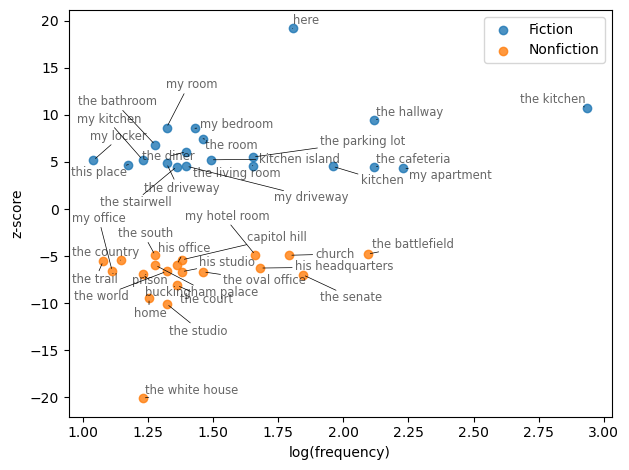

Top terms in Fiction
here             19.19
the kitchen      10.79
the hallway       9.45
my room           8.64
my bedroom        8.58
the room          7.47
the bathroom      6.82
the diner         6.10
the parking lot   5.52
my kitchen        5.24
kitchen island    5.23
my locker         5.18
the driveway      4.86
this place        4.73
the living room   4.61
my driveway       4.56
kitchen           4.54
the stairwell     4.52
the cafeteria     4.45
my apartment      4.38

Top terms in Nonfiction
the white house -20.11
the studio      -10.07
home             -9.48
the court        -8.11
the senate       -6.99
prison           -6.94
the oval office  -6.68
his studio       -6.67
the world        -6.63
my office        -6.61
his headquarters  -6.27
buckingham palace  -5.97
his office       -5.90
the trail        -5.54
the country      -5.44
capitol hill     -5.41
the south        -4.93
church           -4.92
my hotel room    -4.88
the battlefield  -4.80

Comparing GPEs in Female autho

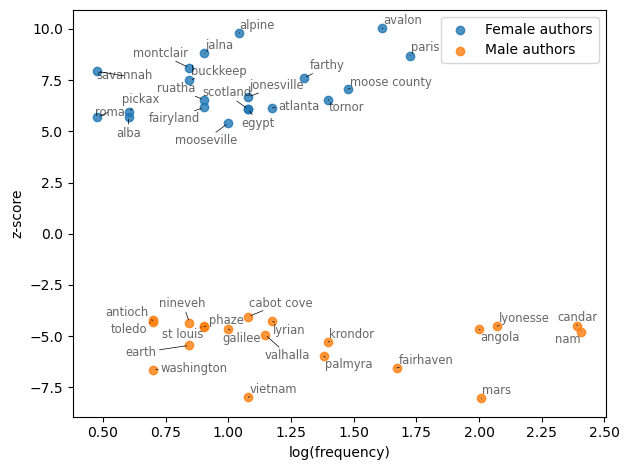

Top terms in Female authors
avalon           10.02
alpine            9.79
jalna             8.82
paris             8.69
montclair         8.10
savannah          7.93
farthy            7.59
buckkeep          7.50
moose county      7.07
jonesville        6.67
tornor            6.54
ruatha            6.54
fairyland         6.17
atlanta           6.14
egypt             6.11
scotland          6.09
pickax            5.92
alba              5.72
roma              5.69
mooseville        5.41

Top terms in Male authors
mars             -8.03
vietnam          -7.98
washington       -6.64
fairhaven        -6.55
palmyra          -5.99
earth            -5.45
krondor          -5.28
valhalla         -4.92
nam              -4.77
angola           -4.67
galilee          -4.64
phaze            -4.55
lyonesse         -4.51
candar           -4.50
st louis         -4.50
nineveh          -4.34
toledo           -4.30
lyrian           -4.28
antioch          -4.23
cabot cove       -4.05

Comparing non-GPEs in Fe

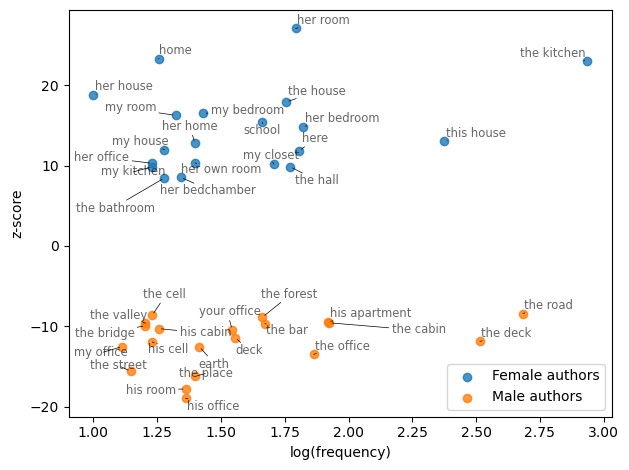

Top terms in Female authors
her room         27.07
home             23.29
the kitchen      23.03
her house        18.80
the house        17.93
my bedroom       16.50
my room          16.25
school           15.40
her bedroom      14.84
this house       13.03
her home         12.80
my house         11.99
here             11.83
her own room     10.33
her office       10.29
my closet        10.17
the hall          9.87
my kitchen        9.86
her bedchamber    8.54
the bathroom      8.47

Top terms in Male authors
his office      -18.96
his room        -17.81
the place       -16.26
the street      -15.60
the office      -13.49
earth           -12.54
my office       -12.53
his cell        -11.96
the deck        -11.89
deck            -11.41
your office     -10.43
his cabin       -10.29
the bridge       -9.94
the bar          -9.67
the valley       -9.61
the cabin        -9.57
his apartment    -9.45
the forest       -8.86
the cell         -8.64
the road         -8.42

Comparing GPEs in she/he

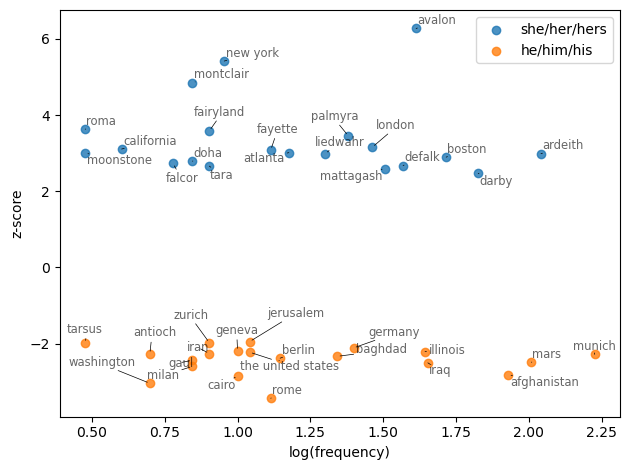

Top terms in she/her/hers
avalon            6.27
new york          5.42
montclair         4.85
roma              3.63
fairyland         3.59
palmyra           3.45
london            3.16
california        3.11
fayette           3.08
atlanta           3.01
moonstone         3.00
liedwahr          2.99
ardeith           2.99
boston            2.90
doha              2.79
falcor            2.73
defalk            2.68
tara              2.66
mattagash         2.59
darby             2.47

Top terms in he/him/his
rome             -3.43
washington       -3.04
cairo            -2.85
afghanistan      -2.81
milan            -2.59
iraq             -2.50
mars             -2.49
gaul             -2.44
berlin           -2.38
baghdad          -2.33
munich           -2.28
antioch          -2.27
iran             -2.26
the united states  -2.22
illinois         -2.21
geneva           -2.20
germany          -2.11
tarsus           -1.99
zurich           -1.98
jerusalem        -1.95

Comparing non-GPEs in she/

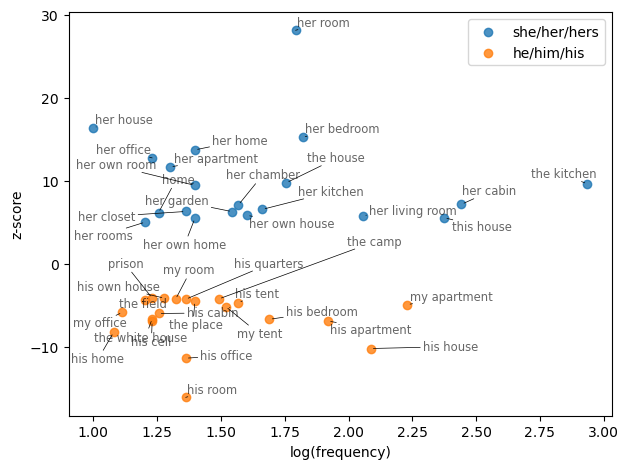

Top terms in she/her/hers
her room         28.13
her house        16.39
her bedroom      15.25
her home         13.71
her office       12.74
her apartment    11.65
the house         9.74
the kitchen       9.62
her own room      9.43
her cabin         7.16
her chamber       7.07
her kitchen       6.55
her closet        6.29
her garden        6.27
home              6.14
her own house     5.82
her living room   5.79
this house        5.53
her own home      5.46
her rooms         5.01

Top terms in he/him/his
his room        -16.12
his office      -11.40
his house       -10.23
his home         -8.29
his cell         -6.93
his apartment    -6.91
his bedroom      -6.71
the white house  -6.65
his cabin        -6.01
my office        -5.87
my tent          -5.18
my apartment     -4.94
his tent         -4.70
the place        -4.55
the field        -4.34
his quarters     -4.29
my room          -4.29
the camp         -4.26
his own house    -4.17
prison           -4.15

Comparing GPEs in Narrator v

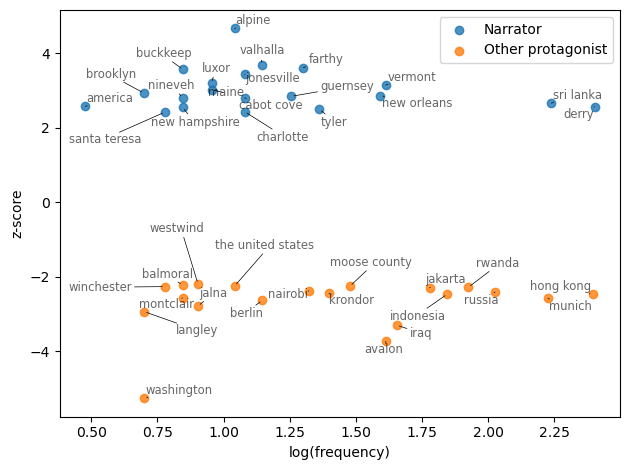

Top terms in Narrator
alpine            4.67
valhalla          3.69
farthy            3.61
buckkeep          3.57
jonesville        3.44
luxor             3.19
vermont           3.15
maine             3.02
brooklyn          2.93
new orleans       2.87
guernsey          2.85
nineveh           2.81
cabot cove        2.80
sri lanka         2.66
america           2.58
derry             2.57
new hampshire     2.56
tyler             2.50
charlotte         2.44
santa teresa      2.42

Top terms in Other protagonist
washington       -5.26
avalon           -3.73
iraq             -3.30
langley          -2.93
jalna            -2.78
berlin           -2.63
munich           -2.58
montclair        -2.57
hong kong        -2.47
indonesia        -2.46
krondor          -2.44
russia           -2.41
nairobi          -2.38
jakarta          -2.29
rwanda           -2.28
winchester       -2.26
moose county     -2.25
the united states  -2.25
balmoral         -2.22
westwind         -2.19

Comparing non-GPEs in N

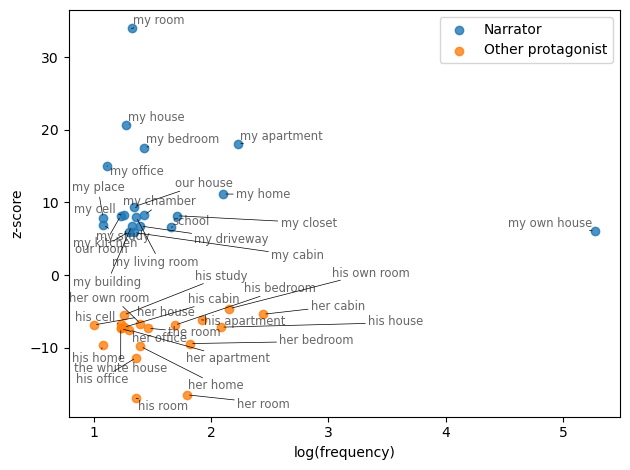

Top terms in Narrator
my room          33.92
my house         20.65
my apartment     18.00
my bedroom       17.55
my office        15.00
my home          11.15
our house         9.40
my chamber        8.26
my cell           8.21
my kitchen        8.18
my closet         8.17
my living room    7.99
my place          7.88
my study          6.93
my driveway       6.75
my building       6.71
school            6.59
my own house      6.03
our room          5.97
my cabin          5.87

Top terms in Other protagonist
his room        -16.93
her room        -16.46
his office      -11.35
her home         -9.80
his home         -9.61
her bedroom      -9.41
her apartment    -7.55
her office       -7.34
the room         -7.30
the white house  -7.25
his cabin        -7.18
his house        -7.16
his bedroom      -6.89
her house        -6.86
his cell         -6.78
her own room     -6.66
his apartment    -6.16
his study        -5.48
her cabin        -5.39
his own room     -4.61


In [21]:
fw_tests = {
    'conlit_fic_nonfic':{
        'g1':{
            'selector':(data.Category=='FIC') & (data.collection=='conlit'),
            'label':'Fiction'
        },
        'g2':{
            'selector':(data.Category=='NON') & (data.collection=='conlit'),
            'label':'Nonfiction'
        }
    },
    'all_fiction_author_gender':{
        'g1':{
            'selector':(data.author_gender=='F') & (data.Category=='FIC'),
            'label':'Female authors'
        },
        'g2':{
            'selector':(data.author_gender=='M') & (data.Category=='FIC'),
            'label':'Male authors'
        }
    },
    'all_fiction_character_gender':{
        'g1':{
            'selector':(data.inf_gender=='she/her/hers') & (data.Category=='FIC'),
            'label':'she/her/hers'
        },
        'g2':{
            'selector':(data.author_gender=='he/him/his') & (data.Category=='FIC'),
            'label':'he/him/his'
        }
    },
    'all_fiction_perspective':{
        'g1':{
            'selector':(data.perspective=='narrator') & (data.Category=='FIC'),
            'label':'Narrator'
        },
        'g2':{
            'selector':(data.author_gender=='he/him/his') & (data.Category=='FIC'),
            'label':'Other protagonist'
        }
    },
}

for test in fw_tests:
    # GPEs
    print(f"\n==============\nComparing GPEs in {fw_tests[test]['g1']['label']} vs. {fw_tests[test]['g2']['label']}\n==============")
    fw_result = fw.bayes_compare_language(
        l1=np.where(fw_tests[test]['g1']['selector'])[0], 
        l2=np.where(fw_tests[test]['g2']['selector'])[0], 
        features=gpe_array,
        prior=gpe_prior,
        cv=cv
    )
    plot_fw(
        fw_result, 
        gpe_array, 
        cv.vocabulary_.keys(),
        label1=fw_tests[test]['g1']['label'],
        label2=fw_tests[test]['g2']['label'],
        name=test+'_gpes',
        print_result=True
    )

    #Non-GPEs
    print(f"\n==============\nComparing non-GPEs in {fw_tests[test]['g1']['label']} vs. {fw_tests[test]['g2']['label']}\n==============")
    fw_result = fw.bayes_compare_language(
        l1=np.where(fw_tests[test]['g1']['selector'])[0], 
        l2=np.where(fw_tests[test]['g2']['selector'])[0], 
        features=nongpe_array,
        prior=nongpe_prior,
        cv=cv_non
    )
    plot_fw(
        fw_result, 
        nongpe_array, 
        cv_non.vocabulary_.keys(),
        label1=fw_tests[test]['g1']['label'],
        label2=fw_tests[test]['g2']['label'],
        name=test+'_nongpes',
        print_result=True
    )